<a href="https://colab.research.google.com/github/AgniKoko/Fetal_ECG_Separation/blob/ilias/Fetal_ECG_Separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECG Example



## **Part 0**: Set-Up

1) Mount Google drive and load dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/MyDrive/Fetal_ECG_Separation'
database_zip = os.path.join(data_dir, 'database-1.0.0.zip')

# train_dir = '/content/train/'
# os.makedirs(train_dir, exist_ok=True)

with zipfile.ZipFile(database_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset extracted successfully.")

Dataset extracted successfully.


2) Install and import libraries.

In [2]:
!pip install wfdb
!pip install scikit-learn
!pip install matplotlib
!pip install pyedflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 67.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyedflib: filename=pyedflib-0.1.40-cp311-cp311-linux_x86_64.whl size=2734981 sha256=e963af2ac2675648616e6fd0

In [3]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.fftpack import fft, fftfreq
from sklearn.decomposition import FastICA
import os
import zipfile
import pyedflib

## **Part 1**: Signal Extraction

1) Read .edf file of choice, extract saved signals and print useful data information. Seperate ground truth signal ('Direct_1') from the abdomen signals.

In [59]:
# Input EDF file path
# ----------------------
file_path = '/content/abdominal-and-direct-fetal-ecg-database-1.0.0/r01.edf'
# ----------------------

edf_file = pyedflib.EdfReader(file_path)

signal_num = edf_file.signals_in_file
signal_labels = edf_file.getSignalLabels()
fs = edf_file.getSampleFrequency(0)  # Fs: Sampling Frequency

signals_list = [edf_file.readSignal(i) for i in range(signal_num)]
signals = np.array(signals_list)

print(f"There are {signal_num} signals/channels in edf file.")
print("Signal Labels:", signal_labels)
print(f"Sampling frequency fs: {fs}Hz")
print("(Num of channels, Num of samples over time) = ", signals.shape)

edf_file._close()

ground_truth = signals[0,:]
abdomen_signals = signals[1:,:]

There are 5 signals/channels in edf file.
Signal Labels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency fs: 1000.0Hz
(Num of channels, Num of samples over time) =  (5, 300000)


2) Plot extracted signals over a specified amount of time.

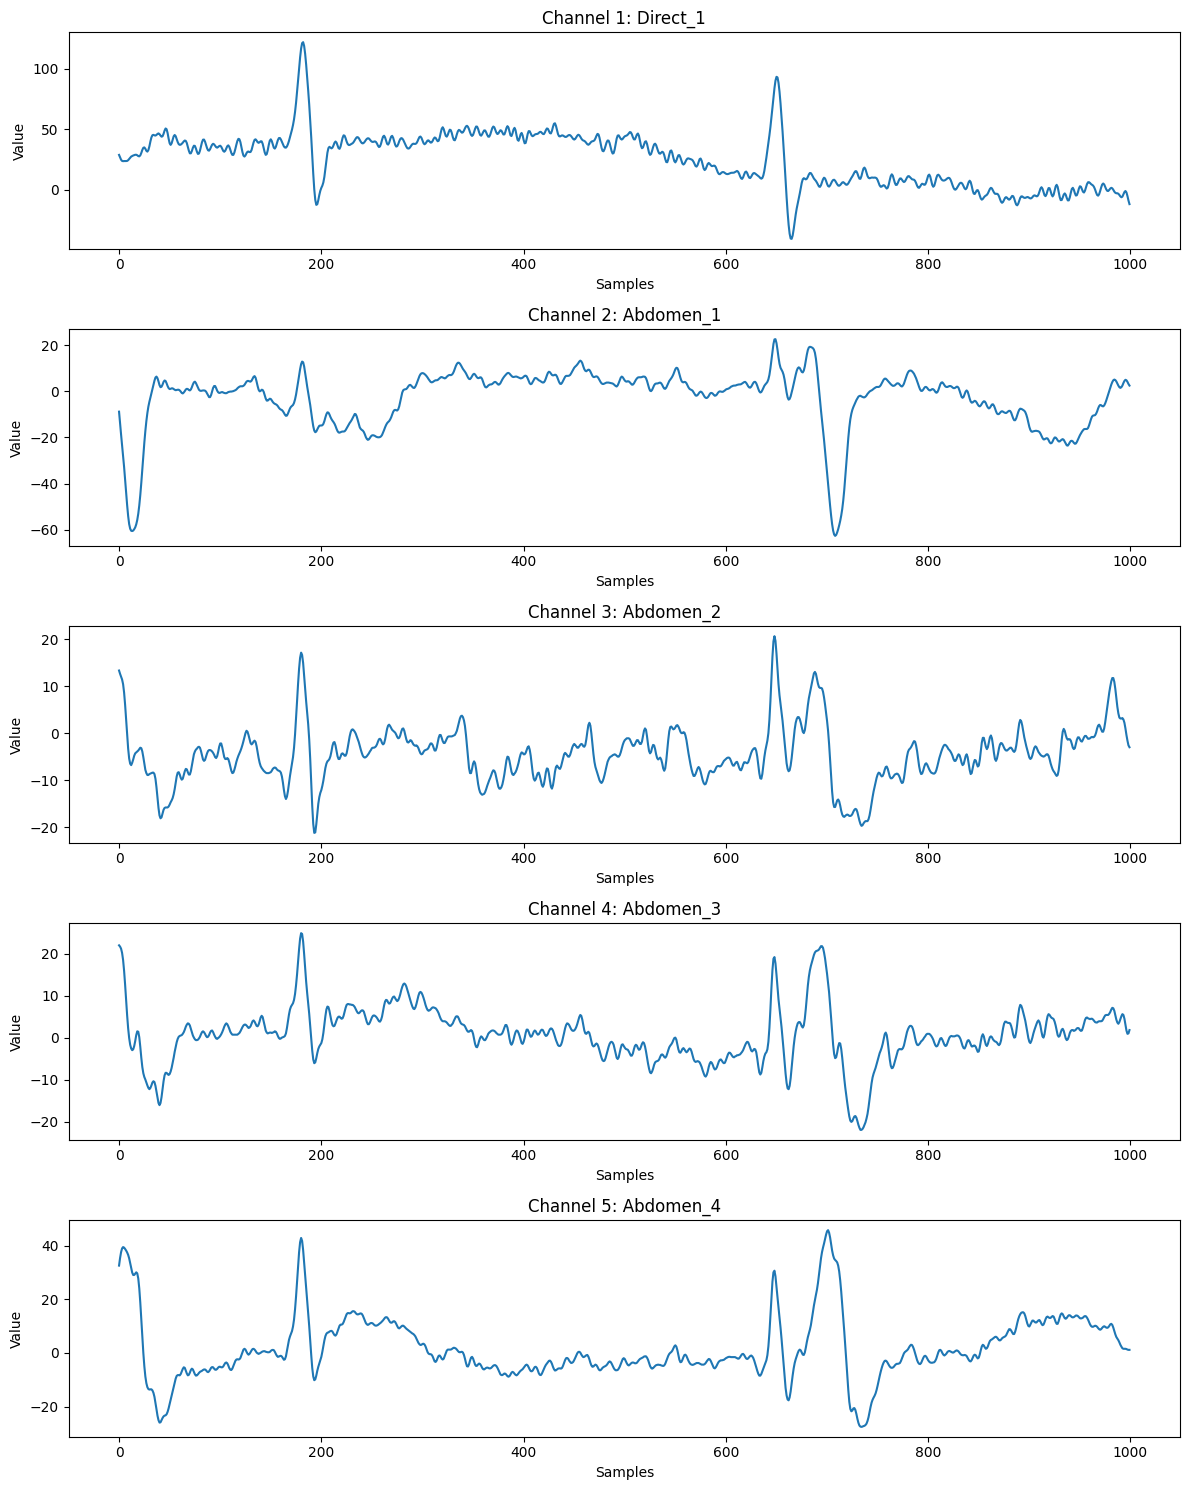

In [60]:
# Input start time and duration (in seconds) for signal plots.
# ----------------------
start_time = 0
duration = 1  # The whole signal lasts 300sec.
# ----------------------

# ex. For duration = 3000 sec, 300 * fs = 300 * 1000 = 300000 samples.
cropped_signals = signals[:, start_time * int(fs):(start_time + duration) * int(fs)]

channel_num = cropped_signals.shape[0]
plt.figure(figsize=(12, 3 * channel_num))
for i in range(channel_num):
    plt.subplot(channel_num, 1, i + 1)
    plt.plot(cropped_signals[i,:])
    plt.title(f'Channel {i+1}: {signal_labels[i]}')
    plt.xlabel('Samples')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

## **Part 2**: Independent Component Analysis (ICA) Application

1) Check if data needs whitening.

In [66]:
abd_signal_mean = np.mean(abdomen_signals,axis=1, keepdims=True)

# Mean array is transposed for clearer reading.
print(f"The mean value of each abdomen channel is:",abd_signal_mean.T)
print()

cov_matrix = np.cov(abdomen_signals)

identity = np.eye(cov_matrix.shape[0])
error = np.linalg.norm(cov_matrix - identity)

print("Covariance Matrix:")
print(cov_matrix)
print()

print("Deviation from Identity (Frobenius norm):", error)

The mean value of each abdomen channel is: [[0.03170482 0.02849677 0.0525478  0.05981291]]

Covariance Matrix:
[[438.77066468  21.57937935  -5.83546577 -52.74160762]
 [ 21.57937935 777.03895811 125.53325188  68.36066034]
 [ -5.83546577 125.53325188 255.55825214  74.51686671]
 [-52.74160762  68.36066034  74.51686671 383.93749103]]

Deviation from Identity (Frobenius norm): 1031.432268879835


Demixing Matrix W:
 [[-0.02215174  0.0302015  -0.00581714 -0.02784461]
 [-0.03717291 -0.00400392  0.00711744  0.0256332 ]
 [-0.02108093 -0.01876878 -0.01470514 -0.02887457]]
Demixing Matrix W shape:
 (3, 4)


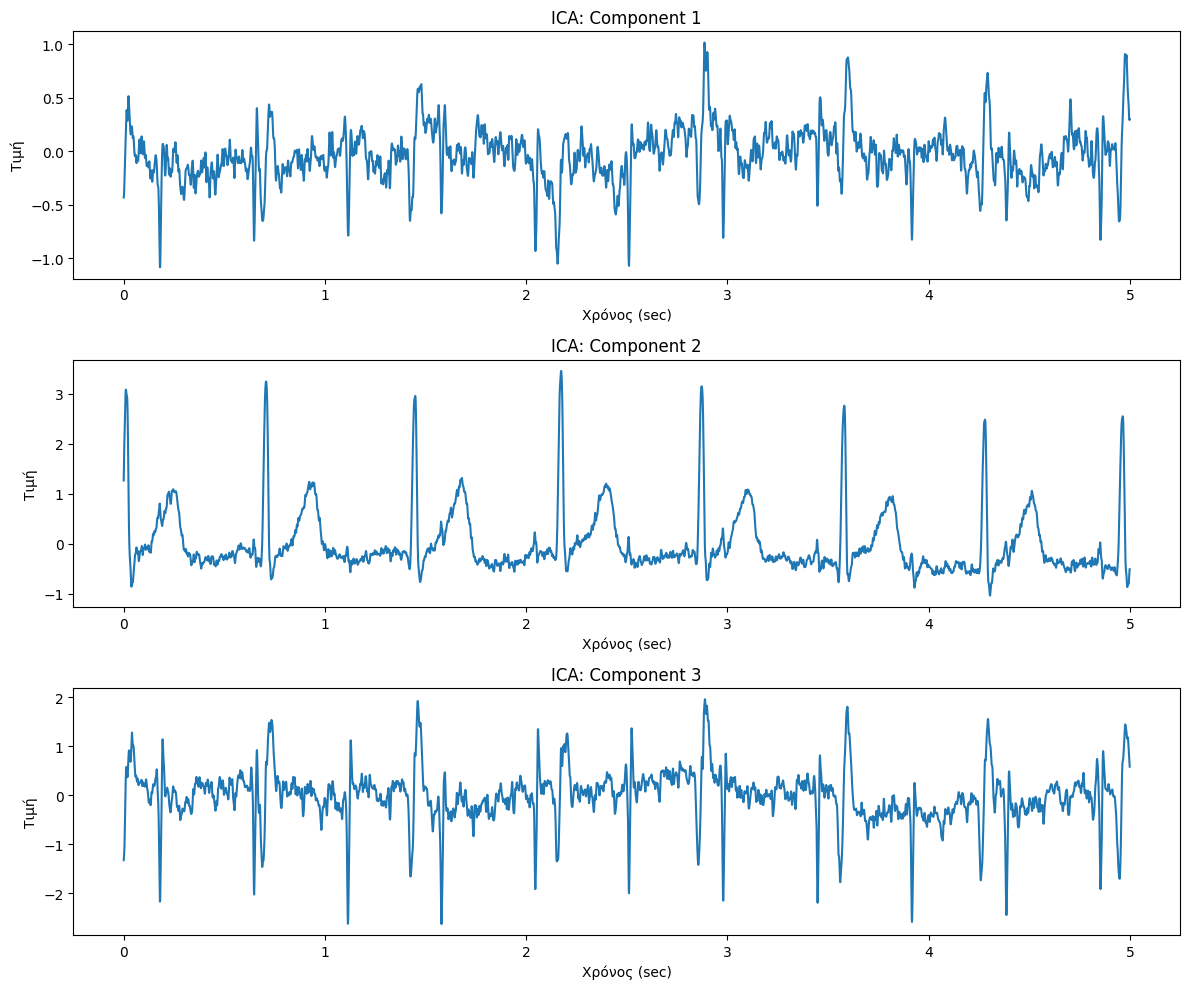

(300000, 5)


In [ ]:
# Εφαρμογή ICA με αριθμό συστατικών (π.χ. 3)
ica = FastICA(n_components=3)
S_ = ica.fit_transform(signals[:,1:])  # ΟΧΙ filtered_signals !!!!!!!
W = ica.components_
print("Demixing Matrix W:\n", W)
print("Demixing Matrix W shape:\n", W.shape)
# Οπτικοποίηση των αποτελεσμάτων (πρώτα 300 δευτερόλεπτα)
time = np.linspace(0, signals[:,1:].shape[0]/fs, signals[:,1:].shape[0])
first_n_sec_S = S_[:n_seconds * int(fs), :]

plt.figure(figsize=(12, 10))
for i in range(S_.shape[1]):
    plt.subplot(S_.shape[1], 1, i + 1)
    plt.plot(time[:n_seconds * int(fs)], first_n_sec_S[:, i])
    plt.title(f'ICA: Component {i+1}')
    plt.xlabel('Χρόνος (sec)')
    plt.ylabel('Τιμή')
plt.tight_layout()
plt.show()
print(signals.shape)

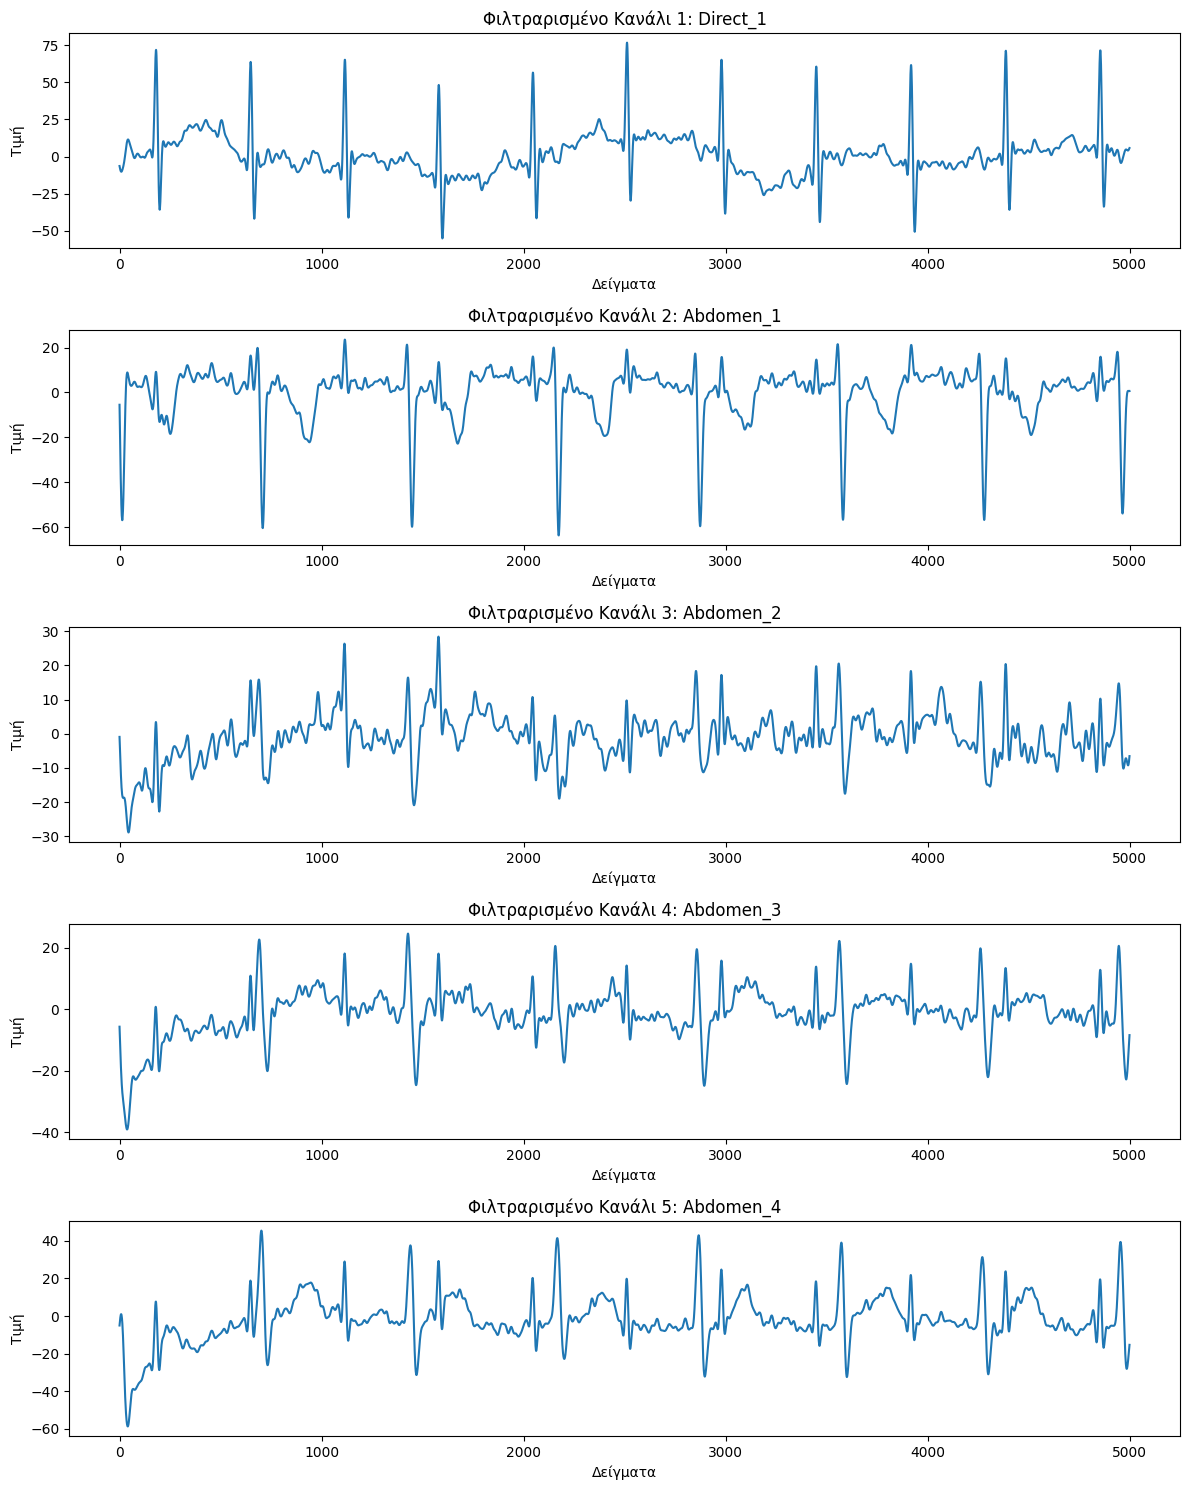

In [6]:
# Συνάρτηση για ζωνοπερατό (bandpass) φιλτράρισμα
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # συχνότητα Nyquist
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Ορισμός παραμέτρων φίλτρου
lowcut = 0.5   # Κατώφλι (Hz)
highcut = 40   # Άνω φράγμα (Hz)

# Εφαρμογή του φίλτρου σε κάθε κανάλι του σήματος
filtered_signals = np.zeros_like(signals)
for i in range(signals.shape[1]):
    filtered_signals[:, i] = bandpass_filter(signals[:, i], lowcut, highcut, fs, order=4)

# Οπτικοποίηση των φιλτραρισμένων σημάτων για τα πρώτα 300 δευτερόλεπτα
n_seconds = 5
first_n_sec_filtered = filtered_signals[:n_seconds * int(fs), :]
n_channels = first_n_sec_filtered.shape[1]

plt.figure(figsize=(12, 3 * n_channels))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i + 1)
    plt.plot(first_n_sec_filtered[:, i])
    plt.title(f'Φιλτραρισμένο Κανάλι {i+1}: {signal_labels[i]}')
    plt.xlabel('Δείγματα')
    plt.ylabel('Τιμή')
plt.tight_layout()
plt.show()

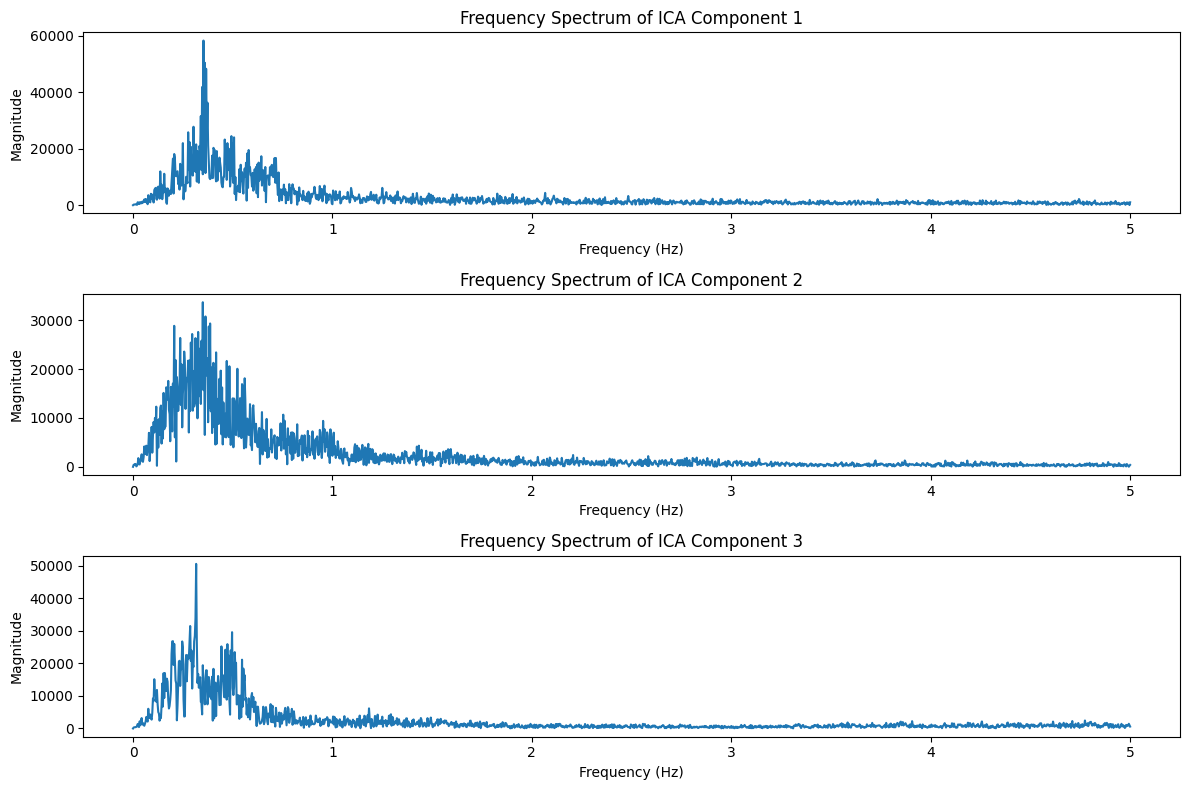

In [ ]:
# # Fourier Transform of ICA components
# frequencies = fftfreq(signals.shape[0], 1/fs)
# plt.figure(figsize=(12, 8))
# for i in range(S_.shape[1]):
#     fft_values = np.abs(fft(S_[:, i]))
#     plt.subplot(S_.shape[1], 1, i + 1)
#     plt.plot(frequencies[:signals.shape[0]//2], fft_values[:signals.shape[0]//2])  # Positive frequencies
#     plt.title(f'Frequency Spectrum of ICA Component {i+1}')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Magnitude')
# plt.tight_layout()
# plt.show()



# Fourier Transform of ICA components (limiting to 0-100 Hz for clarity)
frequencies = fftfreq(signals.shape[0], 1/fs)
plt.figure(figsize=(12, 8))
for i in range(S_.shape[1]):
    fft_values = np.abs(fft(S_[:, i]))
    mask = (frequencies >= 0) & (frequencies <= 5)  # Limit displayed frequencies to 0-100 Hz
    plt.subplot(S_.shape[1], 1, i + 1)
    plt.plot(frequencies[mask], fft_values[mask])
    plt.title(f'Frequency Spectrum of ICA Component {i+1}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

# The Agni Way

Signal Labels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency (fs): 1000.0
Σχήμα signals: (300000, 5)


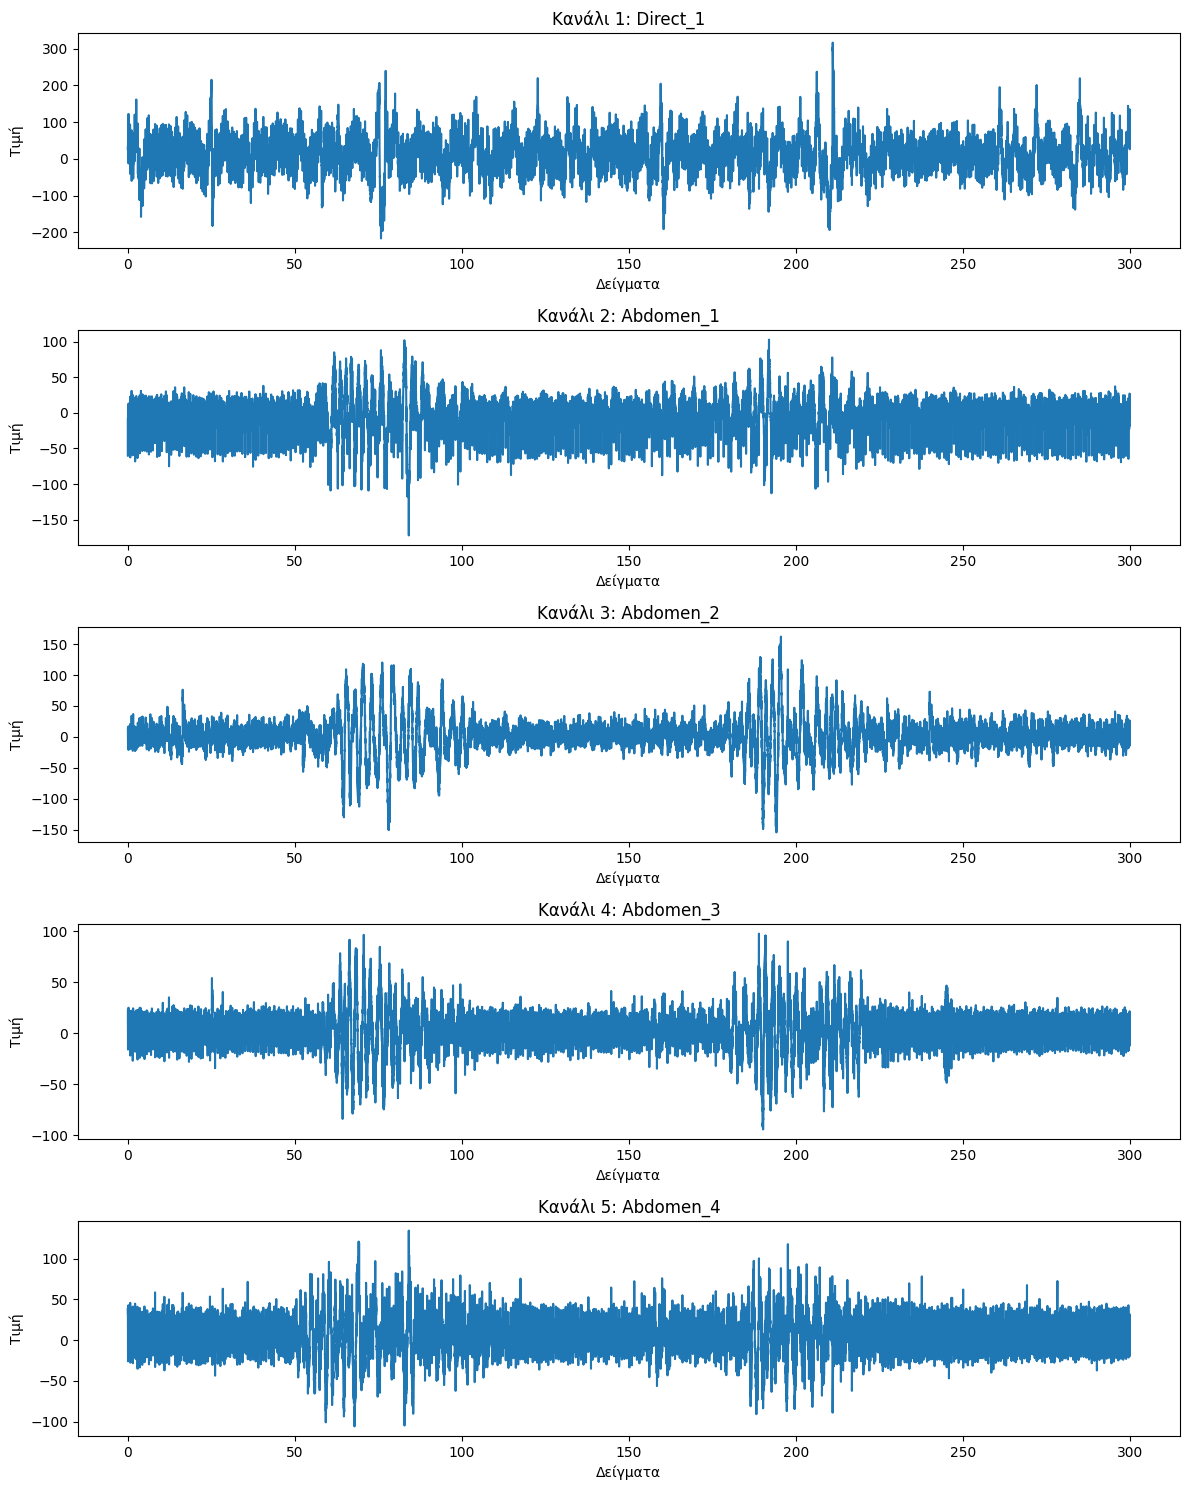

In [ ]:
# Ορισμός της διαδρομής προς το EDF αρχείο
file_path = '/content/abdominal-and-direct-fetal-ecg-database-1.0.0/r01.edf'

# Άνοιγμα του EDF αρχείου
f = pyedflib.EdfReader(file_path)

# Εμφάνιση των ονομάτων των καναλιών
n_signals = f.signals_in_file
signal_labels = f.getSignalLabels()
print("Signal Labels:", signal_labels)

# Ανάγνωση όλων των καναλιών και αποθήκευση σε λίστα
signals_list = [f.readSignal(i) for i in range(n_signals)]
fs = f.getSampleFrequency(0)
print("Sampling frequency (fs):", fs)

f._close()  # Κλείσιμο του αρχείου

# Μετατροπή της λίστας σε NumPy array και transpose για να έχουμε σχήμα (δείγματα x κανάλια)
signals = np.array(signals_list).T
print("Σχήμα signals:", signals.shape)

n_samples = signals.shape[0]
time = np.arange(n_samples) / fs
n_channels = signals.shape[1]

plt.figure(figsize=(12, 3 * n_channels))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i + 1)
    plt.plot(time, signals[:, i])
    plt.title(f'Κανάλι {i+1}: {signal_labels[i]}')
    plt.xlabel('Δείγματα')
    plt.ylabel('Τιμή')

plt.tight_layout()
plt.show()


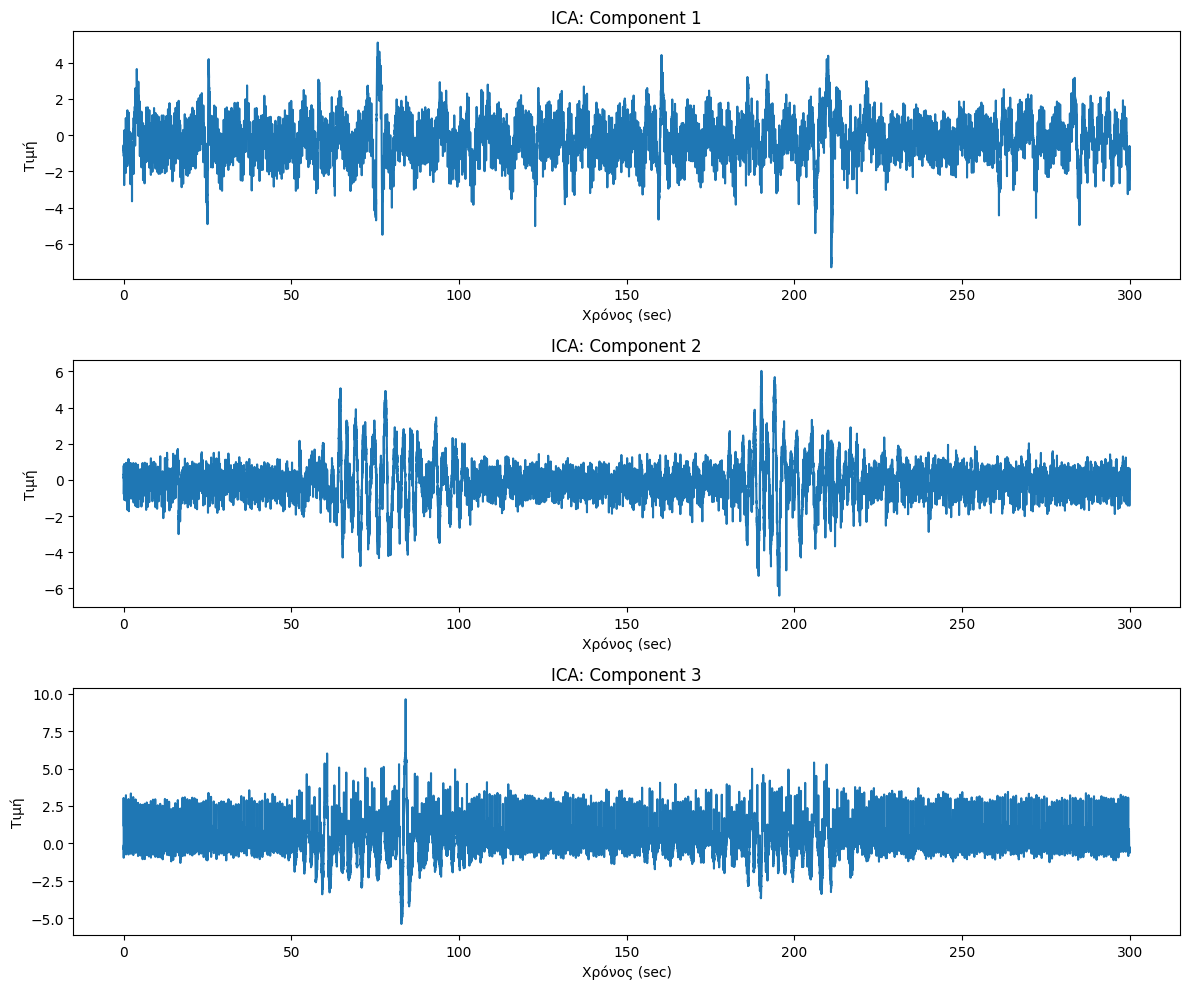

In [ ]:
# Εφαρμογή ICA με αριθμό συστατικών (π.χ. 3)
n_components = 3

ica = FastICA(n_components)
ica_components = ica.fit_transform(signals)  # ΟΧΙ filtered_signals !!!!!!!

time = np.arange(ica_components.shape[0]) / fs

plt.figure(figsize=(12, 10))
for i in range(ica_components.shape[1]):
    plt.subplot(ica_components.shape[1], 1, i + 1)
    plt.plot(time, ica_components[:, i])
    plt.title(f'ICA: Component {i+1}')
    plt.xlabel('Χρόνος (sec)')
    plt.ylabel('Τιμή')
plt.tight_layout()
plt.show()

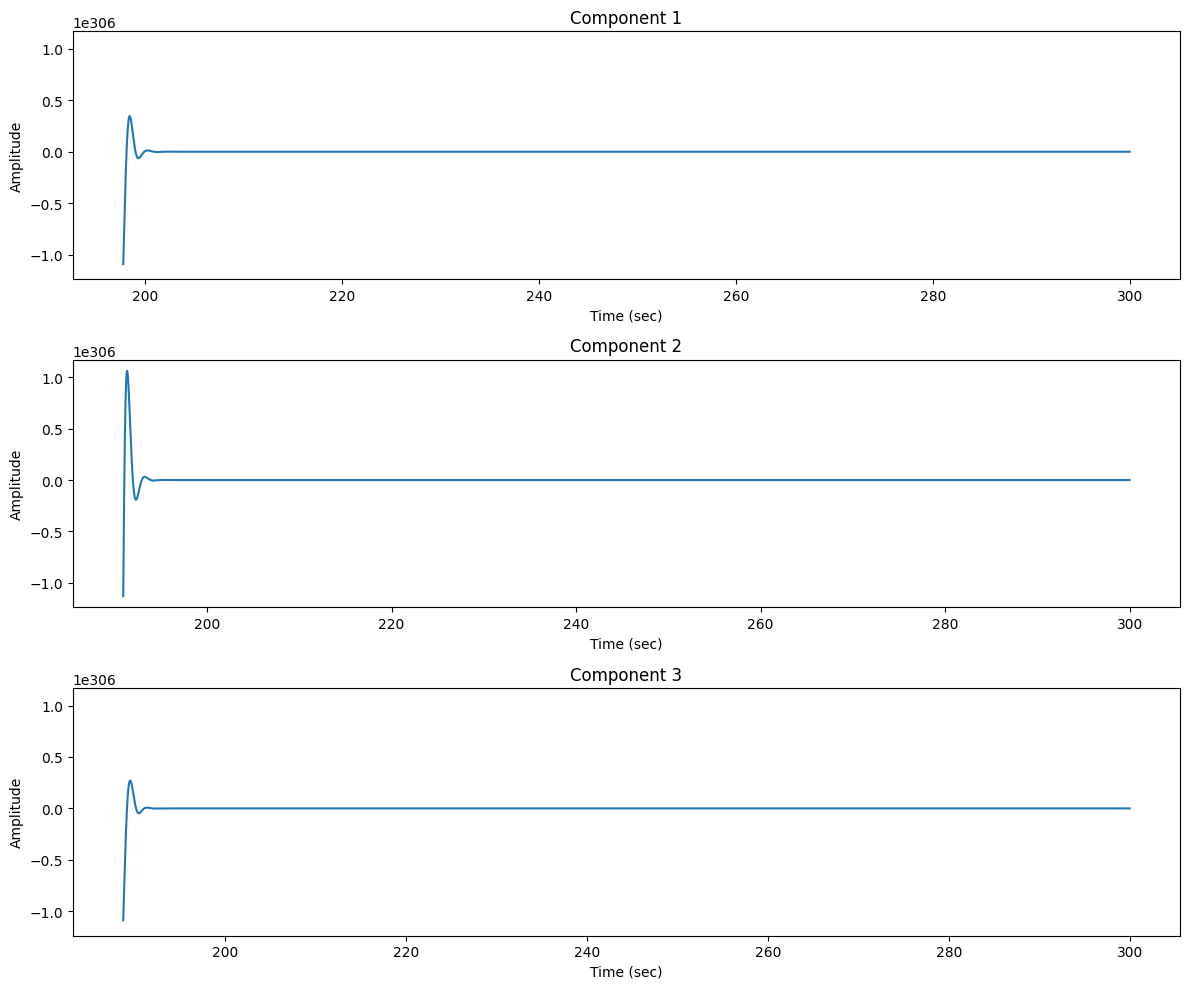

In [ ]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # συχνότητα Nyquist
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

filtered_signals = np.zeros_like(ica_components)

for i in range(ica_components.shape[1]):
    filtered_signals[:, i] = bandpass_filter(
        data=ica_components[:, i],
        lowcut=0.5,
        highcut=40,
        fs=fs,
        order=5
    )

fig, axes = plt.subplots(3, 1, sharey=True, figsize=(12, 10))
for i, ax in enumerate(axes):
    ax.plot(time, filtered_signals[:, i])
    ax.set_title(f'Component {i+1}')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()


In [ ]:
# Number of samples
n = ica_components.shape[0]

# Frequency axis
freqs = np.fft.rfftfreq(n, d=1/fs)

# Compute spectra
fft_vals_list = [
    np.abs(np.fft.rfft(ica_components[:, i]))
    for i in range(ica_components.shape[1])
]

# Replace any NaN or Inf with zero
fft_vals_list = [np.nan_to_num(vals, nan=0.0, posinf=0.0, neginf=0.0)
                 for vals in fft_vals_list]

# Global y‑limit
ymax = max(vals.max() for vals in fft_vals_list)

# Plot
plt.figure(figsize=(12, 8))
for i, fft_vals in enumerate(fft_vals_list):
    plt.subplot(ica_components.shape[1], 1, i+1)
    plt.plot(freqs, fft_vals)
    plt.title(f'Filtered Component {i+1} — Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(0, 50)
    plt.ylim(0, ymax)
plt.tight_layout()
plt.show()


In [ ]:
samples = int(50 * fs)
NFFT = 32
plt.figure(figsize=(12, 10))
for i in range(ica_components.shape[1]):
    plt.subplot(3, 1, i+1)
    plt.specgram(ica_components[:samples, i],
                 mode='psd', scale='dB',
                 NFFT=NFFT, Fs=fs, noverlap=NFFT//2,
                 vmin=-100, vmax=-20)
    plt.yscale('log')
    plt.colorbar(label='PSD (dB/Hz)')
    plt.title(f'Component {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.xlim(0, 10)

plt.tight_layout()
plt.show()


In [ ]:
!pip install PyWavelets

In [ ]:
import pywt

# Parameters
time = np.arange(ica_components.shape[0]) / fs

# Choose wavelet + scales
wavelet = 'cmor1.5-1.0'        # complex Morlet
scales = np.arange(1, 128)    # adjust max scale for resolution

plt.figure(figsize=(12, 10))

for i in range(ica_components.shape[1]):
    signal = ica_components[:, i]

    # Compute CWT
    coeffs, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=1/fs)

    # Plot scalogram
    plt.subplot(3, 1, i+1)
    plt.pcolormesh(time, freqs, np.abs(coeffs), shading='auto')
    plt.title(f'ICA Component {i+1} — Wavelet Scalogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.ylim(0, 100)        # limit to fetal ECG band (~1–100 Hz)

plt.tight_layout()
plt.show()

In [ ]:
end_idx = int(50 * fs)        # index corresponding to 10 seconds
time10 = time[:end_idx]       # first 10 seconds

plt.figure(figsize=(12, 10))
for i in range(ica_components.shape[1]):
    sig10 = ica_components[:end_idx, i]
    coeffs, freqs = pywt.cwt(sig10, scales, wavelet, sampling_period=1/fs)

    plt.subplot(3, 1, i+1)
    plt.pcolormesh(time10, freqs, np.abs(coeffs), shading='auto')
    plt.title(f'ICA Component {i+1} — Wavelet Scalogram (0–10s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.ylim(0, 100)

plt.tight_layout()
plt.show()